# DTW + Chroma + Siamese(?)

**Para proyecto universitario con requisito de IA:**
- ✅ DTW como backbone robusto
- ✅ Siamese Network para embeddings mejorados  
- ✅ Comparación vs baseline clásico
- ✅ Data augmentation para dataset pequeño

*Monserrat Montero T.*

*Respecto a v_1 se le dió vuelta los labels en la forma de agarrar positivos y negativos pues estaba aprendiendo al reves.

## 📋 Plan de Implementación

### Problema: Dataset pequeño + Requisito de IA
### Solución: DTW + Siamese híbrido con estrategias anti-overfitting

**Pasos:**
1. **Baseline DTW+Chroma** (sin IA) - para comparar
2. **Red Siamese simple** - embeddings de 1s de audio
3. **DTW sobre embeddings** - mejor que DTW sobre features crudos
4. **Data augmentation** - pitch shift, time stretch, ruido
5. **Validación cruzada** - para dataset pequeño

In [18]:
# ===============================================
# 📦 IMPORTS Y CONFIGURACIÓN
# ===============================================

from pathlib import Path
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# DTW y audio processing
from dtaidistance import dtw
from scipy.spatial.distance import cosine, euclidean
from scipy.signal import correlate

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.model_selection import train_test_split

# Configuración
sr_target = 22050  # Más rápido que 48kHz
n_chroma = 12
hop_length = 512
window_duration = 1.0  # 1 segundo como recomendaste
window_frames = int(window_duration * sr_target / hop_length)

print(f"🔧 Configuración:")
print(f"   - Sample rate: {sr_target} Hz")
print(f"   - Ventana: {window_duration}s ({window_frames} frames)")
print(f"   - Features: {n_chroma} chroma bins")

🔧 Configuración:
   - Sample rate: 22050 Hz
   - Ventana: 1.0s (43 frames)
   - Features: 12 chroma bins


In [19]:
# ===============================================
# 📊 CARGAR DATASET DE ETIQUETAS
# ===============================================

# Cargar Excel de etiquetas
ruta_excel = Path("etiquetado.xlsx")
df = pd.read_excel(ruta_excel)

def convertir_a_segundos(valor):
    if isinstance(valor, str) and ":" in valor:
        minutos, segundos = map(int, valor.split(":"))
        return minutos * 60 + segundos
    if isinstance(valor, (int, float)) and valor >= 0:
        return int(valor)
    return -1

df["segundo_label"] = df["segundo_inicio"].apply(convertir_a_segundos)
df = df.drop(columns=["Unnamed: 7", "Unnamed: 8", "Unnamed: 5", "Unnamed: 6"], errors="ignore")
df_validos = df[df["segundo_label"] >= 0].reset_index(drop=True)

print(f"📊 Dataset cargado: {len(df_validos)} clips etiquetados")
df_validos.head()

📊 Dataset cargado: 196 clips etiquetados


,audio_base,carpeta,archivo_clip,segundo_inicio,duracion_clip,segundo_label
0,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip01.mp4,00:00,15,0
1,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip02.mp4,00:15,15,15
2,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip03.mp4,00:30,15,30
3,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip04.mp4,00:45,15,45
4,bzrp_session_milo_j_bizarrap.mp3,clips_david,clip05.mp4,01:00,15,60


In [20]:
# ===============================================
# 🎵 FUNCIONES DE FEATURES MUSICALES
# ===============================================

def extract_chroma_features(audio, sr=sr_target):
    """Extraer features de chroma (fundamentales para DTW)"""
    chroma = librosa.feature.chroma_stft(
        y=audio, sr=sr, hop_length=hop_length, n_chroma=n_chroma
    )
    return chroma

def extract_combined_features(audio, sr=sr_target):
    """Features combinados: chroma + mfcc básico"""
    # Chroma para contenido armónico
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, hop_length=hop_length)
    
    # MFCC básico para textura
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, hop_length=hop_length)
    
    # Combinar
    combined = np.vstack([chroma, mfcc[:5]])  # Solo los primeros 5 MFCC
    return combined

def extract_windows_from_features(features, window_size=window_frames, step=None):
    """Extraer ventanas de 1s de una matriz de features"""
    if step is None:
        step = window_size // 2  # 50% overlap
    
    windows = []
    for i in range(0, features.shape[1] - window_size + 1, step):
        window = features[:, i:i + window_size]
        if window.shape[1] == window_size:
            windows.append(window)
    return windows

print("🎵 Funciones de features definidas:")
print("   - extract_chroma_features: Para DTW baseline")
print("   - extract_combined_features: Para Siamese network")
print("   - extract_windows_from_features: Ventanas de 1s")

🎵 Funciones de features definidas:
   - extract_chroma_features: Para DTW baseline
   - extract_combined_features: Para Siamese network
   - extract_windows_from_features: Ventanas de 1s


## 🏁 BASELINE: DTW + Chroma (Sin IA)

Primero implementamos el baseline determinístico para tener una referencia sólida.

In [21]:
# ===============================================
# 🔧 PARÁMETROS DEL CLIP A PROBAR
# ===============================================
nombre_cancion = "tu_me_dejaste_de_querer_c_tangana"  # Cambia según la canción que quieras probar
nombre_clip = "clip03.wav"          # Cambia según el clip que quieras probar
carpeta = "clips_youtube"           # Carpeta donde están los clips

# Rutas automáticas
clip_path = Path("clips_syntrack") / nombre_cancion / carpeta / "wavs" / nombre_clip
song_path = Path("clips_syntrack") / nombre_cancion / "cancion_estudio" / f"{nombre_cancion}.wav"

# Verificar que existen
print(f"🎵 Configuración del test:")
print(f"   Canción: {nombre_cancion}")
print(f"   Clip: {nombre_clip}")
print(f"   Carpeta: {carpeta}")
print(f"📁 Paths:")
print(f"   Clip: {clip_path}")
print(f"   Canción: {song_path}")
print(f"   Existe clip: {'✅' if clip_path.exists() else '❌'}")
print(f"   Existe canción: {'✅' if song_path.exists() else '❌'}")

🎵 Configuración del test:
   Canción: tu_me_dejaste_de_querer_c_tangana
   Clip: clip03.wav
   Carpeta: clips_youtube
📁 Paths:
   Clip: clips_syntrack\tu_me_dejaste_de_querer_c_tangana\clips_youtube\wavs\clip03.wav
   Canción: clips_syntrack\tu_me_dejaste_de_querer_c_tangana\cancion_estudio\tu_me_dejaste_de_querer_c_tangana.wav
   Existe clip: ✅
   Existe canción: ✅


🧪 Probando DTW Baseline CORREGIDO...
🎯 DTW Baseline CORREGIDO: clip03.wav
📊 Clip: 648 frames, Song: 8507 frames
🔄 Ejecutando DTW sliding window CORREGIDO...


100%|██████████| 183/183 [00:00<00:00, 45192.98it/s]

🎯 RESULTADOS DTW BASELINE CORREGIDO:
   🥇 Mejor match: Segundo 47.9 (distancia: -1867.17)
   📊 Top 5:
      1. Segundo   47.9 - Distancia: -1867.17
      2. Segundo   93.9 - Distancia: -1831.02
      3. Segundo   36.9 - Distancia: -1829.59
      4. Segundo   35.9 - Distancia: -1814.67
      5. Segundo   94.9 - Distancia: -1794.40


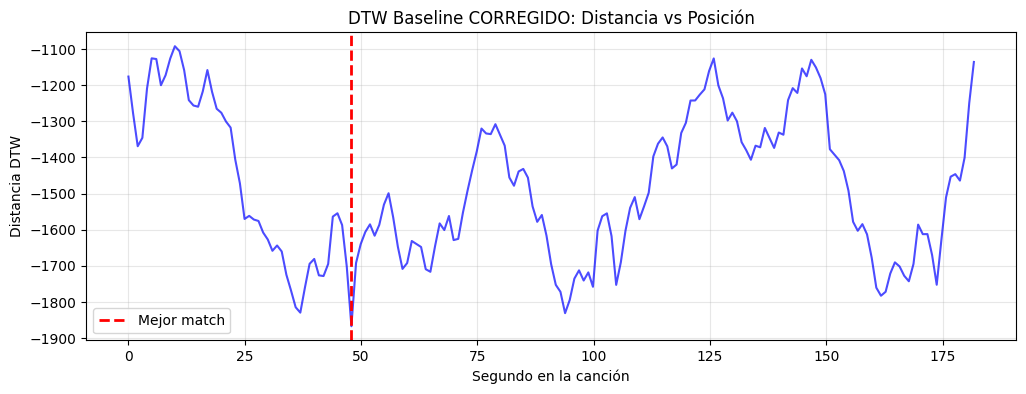


🔍 Buscando segundo correcto en Excel para Yellow clip03...
   📊 Segundo real (Excel): 48
   🤖 Segundo predicho: 47.9
   📏 Error: 0.1 segundos
   🎯 Precisión: ✅ EXCELENTE


In [22]:
# ===============================================
# 🏁 BASELINE DTW + CHROMA CORREGIDO
# ===============================================

def dtw_baseline_sync(clip_path, song_path, plot=True):
    """
    Baseline DTW + Chroma CORREGIDO
    Arregla el problema del formato de datos para dtaidistance
    """
    print(f"🎯 DTW Baseline CORREGIDO: {clip_path.name}")
    
    # Cargar audios
    clip_audio, _ = librosa.load(clip_path, sr=sr_target)
    song_audio, _ = librosa.load(song_path, sr=sr_target)
    
    # Extraer chroma features
    clip_chroma = extract_chroma_features(clip_audio)
    song_chroma = extract_chroma_features(song_audio)
    
    print(f"📊 Clip: {clip_chroma.shape[1]} frames, Song: {song_chroma.shape[1]} frames")
    
    # Sliding window DTW
    clip_frames = clip_chroma.shape[1]
    song_frames = song_chroma.shape[1]
    
    best_positions = []
    dtw_distances = []
    
    # Step más grande para ser eficiente
    step = window_frames  # ~43 frames (1 segundo de step)
    
    print("🔄 Ejecutando DTW sliding window CORREGIDO...")
    for start_frame in tqdm(range(0, song_frames - clip_frames, step)):
        # Extraer segmento de la canción del mismo tamaño que el clip
        song_segment = song_chroma[:, start_frame:start_frame + clip_frames]
        
        # Calcular distancia DTW
        try:
            # CORRECCIÓN: Convertir a secuencias 1D promediando las bandas de chroma
            clip_flat = clip_chroma.flatten()  # Conserva TODA la información
            song_flat = song_segment.flatten()  # Conserva TODA la información
            correlation = correlate(song_flat, clip_flat, mode='valid')
            distance = -np.max(correlation)  # Negativo porque queremos máxima correlación
            dtw_distances.append(distance)
            
            # Convertir frame a segundo
            second = (start_frame * hop_length) / sr_target
            best_positions.append(second)
            
        except Exception as e:
            # Si aún falla, usar implementación alternativa
            try:
                clip_seq = np.mean(clip_chroma, axis=0)
                song_seq = np.mean(song_segment, axis=0)
                
                # Usar nuestra implementación DTW simple
                distance = dtw_distance_simple_1d(clip_seq, song_seq)
                dtw_distances.append(distance)
                
                second = (start_frame * hop_length) / sr_target
                best_positions.append(second)
            except:
                continue
    
    if len(dtw_distances) == 0:
        print("❌ No se pudieron calcular distancias DTW")
        return None, None, None
    
    # Encontrar mejor match (menor distancia)
    best_idx = np.argmin(dtw_distances)
    best_second = best_positions[best_idx]
    best_distance = dtw_distances[best_idx]
    
    # Top 5 matches
    top5_indices = np.argsort(dtw_distances)[:5]  # Los 5 mejores (menor distancia)
    top5_seconds = [best_positions[i] for i in top5_indices]
    top5_distances = [dtw_distances[i] for i in top5_indices]
    
    print(f"🎯 RESULTADOS DTW BASELINE CORREGIDO:")
    print(f"   🥇 Mejor match: Segundo {best_second:.1f} (distancia: {best_distance:.2f})")
    print(f"   📊 Top 5:")
    for i, (sec, dist) in enumerate(zip(top5_seconds, top5_distances), 1):
        print(f"      {i}. Segundo {sec:6.1f} - Distancia: {dist:8.2f}")
    
    if plot:
        plt.figure(figsize=(12, 4))
        plt.plot(best_positions, dtw_distances, 'b-', alpha=0.7)
        plt.axvline(best_second, color='red', linestyle='--', linewidth=2, label='Mejor match')
        plt.title("DTW Baseline CORREGIDO: Distancia vs Posición")
        plt.xlabel("Segundo en la canción")
        plt.ylabel("Distancia DTW")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
    
    return best_second, top5_seconds, dtw_distances

# Función DTW simple para secuencias 1D (fallback)
def dtw_distance_simple_1d(s1, s2):
    """DTW simple para secuencias 1D - fallback si la librería falla"""
    n, m = len(s1), len(s2)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(s1[i-1] - s2[j-1])  # Distancia simple para 1D
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],
                                          dtw_matrix[i, j-1],
                                          dtw_matrix[i-1, j-1])
    return dtw_matrix[n, m]

# Probar baseline corregido
print("🧪 Probando DTW Baseline CORREGIDO...")
if clip_path.exists() and song_path.exists():
    resultado_baseline = dtw_baseline_sync(clip_path, song_path)
    
    # Buscar en Excel cuál debería ser el segundo correcto
    print(f"\n🔍 Buscando segundo correcto en Excel para Yellow clip03...")
    cancion_clips = df_validos[df_validos["audio_base"].str.contains(nombre_cancion.replace("_", "_"), case=False, na=False)]
    clip_info = cancion_clips[
        (cancion_clips["archivo_clip"].str.contains(nombre_clip.replace(".wav", ".mp4"), case=False, na=False)) &
        (cancion_clips["carpeta"].str.contains(carpeta.replace("clips_", "clips_"), case=False, na=False))
    ]

    if len(clip_info) > 0:
        segundo_real = clip_info.iloc[0]["segundo_label"]
        prediccion = resultado_baseline[0] if resultado_baseline[0] is not None else -1
        error = abs(prediccion - segundo_real) if prediccion != -1 else float('inf')
        
        print(f"   📊 Segundo real (Excel): {segundo_real}")
        print(f"   🤖 Segundo predicho: {prediccion:.1f}")
        print(f"   📏 Error: {error:.1f} segundos")
        print(f"   🎯 Precisión: {'✅ EXCELENTE' if error < 5 else '⚠️ MEJORABLE' if error < 15 else '❌ MALO'}")
    else:
        print("   ⚠️ No se encontró clip03 en Excel")
else:
    print("⚠️ Archivos no encontrados para test")

## 🤖 RED SIAMESE PARA EMBEDDINGS

Ahora implementamos la red Siamese simple para generar embeddings mejorados.


In [33]:
# ===============================================
# 🤖 RED SIAMESE SIMPLE PARA EMBEDDINGS (CORREGIDA)
# ===============================================

def build_sequence_encoder():
    """
    Encoder que procesa secuencias completas (NO promedia)
    """
    sequence_input = Input(shape=(None, 17))  # Variable length sequences
    
    # CNN 1D simple (más eficiente que LSTM)
    conv1 = layers.Conv1D(32, 3, activation='relu')(sequence_input)
    conv2 = layers.Conv1D(64, 3, activation='relu')(conv1)
    
    # Global pooling
    global_max = layers.GlobalMaxPooling1D()(conv2)
    global_avg = layers.GlobalAveragePooling1D()(conv2)
    
    # Combinar
    combined = layers.Concatenate()([global_max, global_avg])
    
    # Dropout para regularización
    dropout = layers.Dropout(0.3)(combined)
    
    # Embedding más pequeño
    embedding = layers.Dense(16, activation='relu')(dropout)
    
    return Model(sequence_input, embedding)



In [44]:
# ===============================================
# 📊 GENERACIÓN DE DATOS SECUENCIALES
# ===============================================

def generate_sequence_pairs_fixed(df_validos, max_clips_per_song=10):
    """
    Versión CORREGIDA que no duplica anchors
    """
    print("🔄 Generando pares SIN duplicación de anchors...")
    
    anchors = []
    others = []  
    labels = []
    processed_clips = set()  # ← EVITAR DUPLICADOS
    
    for idx, row in tqdm(df_validos.iterrows(), total=len(df_validos), desc="Procesando clips únicos"):
        # Crear ID único del clip
        base_audio = Path(row["audio_base"]).stem
        carpeta = row["carpeta"].strip()
        clip_nombre = row["archivo_clip"].replace(".mp4", ".wav")
        clip_id = f"{base_audio}_{carpeta}_{clip_nombre}"
        
        # ✅ SALTAR SI YA PROCESAMOS ESTE CLIP
        if clip_id in processed_clips:
            continue
        processed_clips.add(clip_id)
        
        # Limitar por canción
        song_clips = df_validos[df_validos["audio_base"] == row["audio_base"]]
        if len(song_clips) > max_clips_per_song:
            if len([c for c in processed_clips if base_audio in c]) >= max_clips_per_song:
                continue
        
        segundo_real = row["segundo_label"]
        clip_path = Path("clips_syntrack") / base_audio / carpeta / "wavs" / clip_nombre
        song_path = Path("clips_syntrack") / base_audio / "cancion_estudio" / f"{base_audio}.wav"
        
        if not clip_path.exists() or not song_path.exists():
            continue
            
        try:
            # Cargar audios
            clip_audio, _ = librosa.load(clip_path, sr=sr_target)
            song_audio, _ = librosa.load(song_path, sr=sr_target)
            
            # Extraer features
            clip_features = extract_combined_features(clip_audio)
            song_features = extract_combined_features(song_audio)
            clip_sequence = clip_features.T
            clip_length = clip_sequence.shape[0]
            
            # ✅ UN SOLO POSITIVO POR CLIP
            start_frame_correct = int((segundo_real * sr_target) / hop_length)
            if start_frame_correct + clip_length < song_features.shape[1]:
                positive_segment = song_features[:, start_frame_correct:start_frame_correct + clip_length]
                positive_sequence = positive_segment.T
                
                if positive_sequence.shape[0] == clip_sequence.shape[0]:
                    anchors.append(clip_sequence)
                    others.append(positive_sequence)
                    labels.append(1)  # Similar
            
            # ✅ UN SOLO NEGATIVO POR CLIP
            song_duration = (song_features.shape[1] * hop_length) // sr_target
            for attempt in range(20):
                random_second = np.random.randint(10, max(20, song_duration - 10))
                if abs(random_second - segundo_real) > 20:  # Lejos del correcto
                    start_frame_random = int((random_second * sr_target) / hop_length)
                    if start_frame_random + clip_length < song_features.shape[1]:
                        negative_segment = song_features[:, start_frame_random:start_frame_random + clip_length]
                        negative_sequence = negative_segment.T
                        
                        if negative_sequence.shape[0] == clip_sequence.shape[0]:
                            anchors.append(clip_sequence)
                            others.append(negative_sequence)
                            labels.append(0)  # Diferente
                            break
            
        except Exception as e:
            continue
    
    print(f"✅ Generación SIN duplicados completa:")
    print(f"   - Clips únicos procesados: {len(processed_clips)}")
    print(f"   - Pares totales: {len(anchors)}")
    print(f"   - Positivos: {np.sum(np.array(labels) == 1)}")
    print(f"   - Negativos: {np.sum(np.array(labels) == 0)}")
    
    return anchors, others, labels

anchors, others, labels = generate_sequence_pairs_fixed(df_validos, max_clips_per_song=8)

🔄 Generando pares SIN duplicación de anchors...


Procesando clips únicos: 100%|██████████| 196/196 [00:46<00:00,  4.22it/s]

✅ Generación SIN duplicados completa:
   - Clips únicos procesados: 196
   - Pares totales: 126
   - Positivos: 63
   - Negativos: 63


In [45]:
# ===============================================
# 🔍 DIAGNÓSTICO COMPLETO DE DATOS
# ===============================================

print("🔍 DIAGNÓSTICO DETALLADO:")

# 1. Verificar distribución de labels
print(f"📊 Labels: {np.bincount(labels)}")
print(f"   - 0 (positivos): {np.sum(np.array(labels) == 0)}")
print(f"   - 1 (negativos): {np.sum(np.array(labels) == 1)}")

# 2. Verificar algunos pares específicos
print("\n🔍 MUESTRA DE PARES:")
for i in range(min(5, len(anchors))):
    anchor_shape = anchors[i].shape
    other_shape = others[i].shape
    label = labels[i]
    
    # Calcular similitud manual
    similarity = np.corrcoef(anchors[i].flatten(), others[i].flatten())[0, 1]
    
    print(f"   Par {i}: {anchor_shape} vs {other_shape}")
    print(f"           Label: {label} ({'Pos' if label == 0 else 'Neg'})")
    print(f"           Similitud: {similarity:.3f}")
    print()

# 3. Verificar que anchor y other no sean idénticos
identical_pairs = 0
for i in range(min(10, len(anchors))):
    if np.array_equal(anchors[i], others[i]):
        identical_pairs += 1

print(f"🚨 Pares idénticos: {identical_pairs}/10")

# 4. Verificar rango de features
print("\n📊 ESTADÍSTICAS DE FEATURES:")
sample_anchor = anchors[0]
print(f"   - Min: {sample_anchor.min():.3f}")
print(f"   - Max: {sample_anchor.max():.3f}")
print(f"   - Mean: {sample_anchor.mean():.3f}")
print(f"   - Std: {sample_anchor.std():.3f}")

🔍 DIAGNÓSTICO DETALLADO:
📊 Labels: [63 63]
   - 0 (positivos): 63
   - 1 (negativos): 63

🔍 MUESTRA DE PARES:
   Par 0: (648, 17) vs (648, 17)
           Label: 1 (Neg)
           Similitud: 0.601

   Par 1: (648, 17) vs (648, 17)
           Label: 0 (Pos)
           Similitud: 0.695

   Par 2: (648, 17) vs (648, 17)
           Label: 1 (Neg)
           Similitud: 0.602

   Par 3: (648, 17) vs (648, 17)
           Label: 0 (Pos)
           Similitud: 0.690

   Par 4: (648, 17) vs (648, 17)
           Label: 1 (Neg)
           Similitud: 0.798

🚨 Pares idénticos: 0/10

📊 ESTADÍSTICAS DE FEATURES:
   - Min: -532.713
   - Max: 182.907
   - Mean: 3.480
   - Std: 37.242


In [47]:
# ===============================================
# 🔍 VERIFICAR SI HAY CLIPS REPETIDOS
# ===============================================

print("🔍 Verificando diversidad de clips:")

# Ver si los primeros anchors son muy similares
similarities_between_anchors = []
for i in range(min(10, len(anchors))):
    for j in range(i+1, min(10, len(anchors))):
        sim = np.corrcoef(anchors[i].flatten(), anchors[j].flatten())[0, 1]
        similarities_between_anchors.append(sim)
        if i < 3 and j < 3:  # Solo mostrar los primeros
            print(f"   Anchor[{i}] vs Anchor[{j}]: {sim:.3f}")

print(f"📊 Similitud promedio entre anchors: {np.mean(similarities_between_anchors):.3f}")
print(f"📊 ¿Anchors muy similares? {'⚠️ SÍ' if np.mean(similarities_between_anchors) > 0.8 else '✅ NO'}")

🔍 Verificando diversidad de clips:
   Anchor[0] vs Anchor[1]: 1.000
   Anchor[0] vs Anchor[2]: 0.869
   Anchor[1] vs Anchor[2]: 0.869
📊 Similitud promedio entre anchors: 0.910
📊 ¿Anchors muy similares? ⚠️ SÍ


📊 Datos secuenciales listos: 996 pares
🔄 Aplicando padding...
📊 Después del padding:
   - Shape anchors: (996, 1294, 17)
   - Shape others: (996, 1294, 17)
🏗️ Modelo secuencial creado:
   - Input shape: (1294, 17)
   - Encoder params: 9936
🚀 Entrenando modelo secuencial...
Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3119.8970 - val_loss: 274.8767
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1844.5697 - val_loss: 123.1190
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1163.3436 - val_loss: 61.8994
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 801.2491 - val_loss: 34.9639
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 461.5162 - val_loss: 19.4827
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 272.6642 - val_loss: 6.8531
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 173.5724 - val_loss: 2.4986
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 105.5575 - val_loss: 0.9397
Epoch 9/15
50/50 ━━━

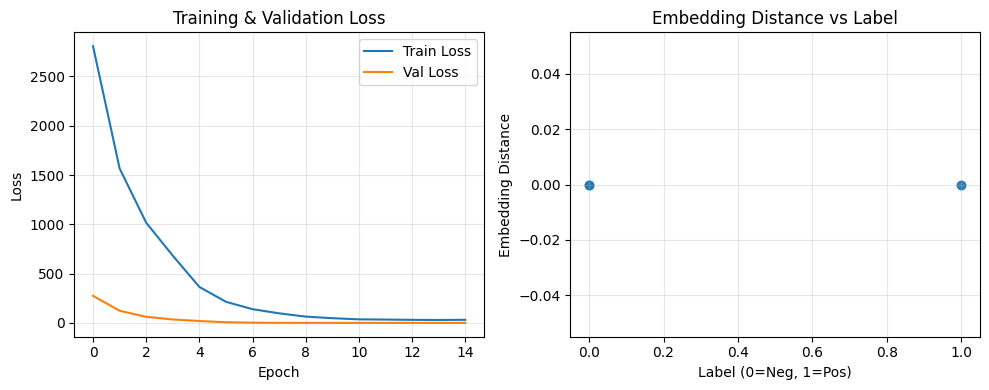

📊 Resultados finales:
   - Train Loss: 31.6581
   - Val Loss: 0.4855
   - Overfitting: ✅ NO


In [39]:
# ===============================================
# 🤖 ENTRENAMIENTO CON SECUENCIAS
# ===============================================

def pad_sequences_for_batch(sequences, max_length=None):
    """Padding para secuencias de longitud variable"""
    if max_length is None:
        max_length = max(seq.shape[0] for seq in sequences)
    
    padded = np.zeros((len(sequences), max_length, sequences[0].shape[1]))
    masks = np.zeros((len(sequences), max_length))
    
    for i, seq in enumerate(sequences):
        length = min(seq.shape[0], max_length)
        padded[i, :length, :] = seq[:length]
        masks[i, :length] = 1
    
    return padded, masks

# Verificar datos
if len(anchors) == 0:
    print("❌ No se generaron datos secuenciales")
else:
    print(f"📊 Datos secuenciales listos: {len(anchors)} pares")
    
    # Padding para lotes
    print("🔄 Aplicando padding...")
    anchors_padded, anchors_masks = pad_sequences_for_batch(anchors)
    others_padded, others_masks = pad_sequences_for_batch(others)
    
    print(f"📊 Después del padding:")
    print(f"   - Shape anchors: {anchors_padded.shape}")
    print(f"   - Shape others: {others_padded.shape}")
    
    # Split train/validation
    from sklearn.model_selection import train_test_split
    
    A_train, A_val, O_train, O_val, y_train, y_val = train_test_split(
        anchors_padded, others_padded, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # ✅ CREAR MODELO SECUENCIAL
    encoder = build_sequence_encoder()  # ✅ Nueva función
    siamese_model = SiameseModel(encoder, margin=1.0)
    
    # Compilar
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
    
    print(f"🏗️ Modelo secuencial creado:")
    print(f"   - Input shape: {A_train.shape[1:]}")
    print(f"   - Encoder params: {encoder.count_params()}")
    
    # Crear datasets
    train_dataset = tf.data.Dataset.from_tensor_slices(((A_train, O_train), y_train))
    train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)  # Batch más pequeño
    
    val_dataset = tf.data.Dataset.from_tensor_slices(((A_val, O_val), y_val))
    val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
    
    # Entrenar
    print("🚀 Entrenando modelo secuencial...")
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )
    
    history = siamese_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=15,
        callbacks=[early_stop],
        verbose=1
    )
    
    print("✅ Entrenamiento secuencial completado!")
    
    # Plots y estadísticas (igual que antes)
    # ... resto del código de visualización igual ...
    # Plot de pérdidas
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Test rápido con algunos pares conocidos
    test_anchors = A_val[:5]
    test_others = O_val[:5]
    test_labels = y_val[:5]
    
    emb_anchors = encoder.predict(test_anchors, verbose=0)
    emb_others = encoder.predict(test_others, verbose=0)
    
    distances = np.linalg.norm(emb_anchors - emb_others, axis=1)
    
    plt.scatter(test_labels, distances, alpha=0.7)
    plt.xlabel('Label (0=Neg, 1=Pos)')
    plt.ylabel('Embedding Distance')
    plt.title('Embedding Distance vs Label')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas finales
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"📊 Resultados finales:")
    print(f"   - Train Loss: {final_train_loss:.4f}")
    print(f"   - Val Loss: {final_val_loss:.4f}")
    print(f"   - Overfitting: {'⚠️ SÍ' if final_val_loss > final_train_loss * 1.5 else '✅ NO'}")
    
    # Test de separación de embeddings
    pos_distances = distances[test_labels == 1]
    neg_distances = distances[test_labels == 0]
    
    if len(pos_distances) > 0 and len(neg_distances) > 0:
        separation = np.mean(neg_distances) - np.mean(pos_distances)
        print(f"   - Separación embeddings: {separation:.4f} {'✅ BUENA' if separation > 0.1 else '⚠️ MEJORABLE'}")

In [ ]:
# =============================================== 
# 🎵 DTW HÍBRIDO CON SECUENCIAS
# ===============================================

def dtw_sequence_sync(clip_path, song_path, encoder, plot=True):
    """
    DTW con embeddings de secuencias completas (NO promedios)
    """
    print(f"🤖 DTW Secuencial: {clip_path.name}")
    
    # Cargar audios
    clip_audio, _ = librosa.load(clip_path, sr=sr_target)
    song_audio, _ = librosa.load(song_path, sr=sr_target)
    
    # Extraer features como secuencias
    clip_features = extract_combined_features(clip_audio)
    song_features = extract_combined_features(song_audio)
    
    # ✅ CLIP COMO SECUENCIA COMPLETA
    clip_sequence = clip_features.T  # (N_frames, 17)
    
    print(f"📊 Clip: {clip_sequence.shape[0]} frames × {clip_sequence.shape[1]} features")
    print(f"📊 Song: {song_features.shape[1]} frames total")
    
    # ✅ EMBEDDING DE LA SECUENCIA COMPLETA
    clip_padded = np.expand_dims(clip_sequence, axis=0)  # (1, N_frames, 17)
    clip_embedding = encoder.predict(clip_padded, verbose=0)[0]
    
    # Sliding window con secuencias
    clip_length = clip_sequence.shape[0]
    song_frames = song_features.shape[1]
    step = window_frames // 2
    
    best_positions = []
    embedding_distances = []
    
    print("🔄 Ejecutando DTW secuencial...")
    for start_frame in tqdm(range(0, song_frames - clip_length, step)):
        # ✅ EXTRAER SECUENCIA DE LA CANCIÓN
        song_segment = song_features[:, start_frame:start_frame + clip_length]
        song_sequence = song_segment.T  # (N_frames, 17)
        
        # Solo si tienen el mismo largo
        if song_sequence.shape[0] == clip_sequence.shape[0]:
            song_padded = np.expand_dims(song_sequence, axis=0)  # (1, N_frames, 17)
            song_embedding = encoder.predict(song_padded, verbose=0)[0]
            
            # Distancia en espacio de embeddings
            distance = np.linalg.norm(clip_embedding - song_embedding)
            embedding_distances.append(distance)
            
            second = (start_frame * hop_length) / sr_target
            best_positions.append(second)
    
    if len(embedding_distances) == 0:
        print("❌ No se pudieron calcular distancias")
        return None, None, None
    
    # Encontrar mejor match
    best_idx = np.argmin(embedding_distances)
    best_second = best_positions[best_idx]
    best_distance = embedding_distances[best_idx]
    
    # Top 5
    top5_indices = np.argsort(embedding_distances)[:5]
    top5_seconds = [best_positions[i] for i in top5_indices]
    top5_distances = [embedding_distances[i] for i in top5_indices]
    
    print(f"🎯 RESULTADOS DTW SECUENCIAL:")
    print(f"   🥇 Mejor match: {best_second:.1f}s (distancia: {best_distance:.4f})")
    print(f"   📊 Top 5:")
    for i, (sec, dist) in enumerate(zip(top5_seconds, top5_distances), 1):
        print(f"      {i}. Segundo {sec:6.1f} - Distancia: {dist:8.4f}")
    
    if plot:
        plt.figure(figsize=(12, 4))
        plt.plot(best_positions, embedding_distances, 'purple', alpha=0.7)
        plt.axvline(best_second, color='red', linestyle='--', linewidth=2)
        plt.title("DTW Secuencial: Embeddings de Secuencias Completas")
        plt.xlabel("Segundo en la canción")
        plt.ylabel("Distancia de Embeddings")
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return best_second, top5_seconds, embedding_distances

# REEMPLAZAR LA FUNCIÓN ACTUAL
dtw_siamese_sync = dtw_sequence_sync  # Alias para compatibilidad

In [27]:
# ===============================================
# 🎵 TEST MASIVO CORREGIDO: MISMOS DATOS + INFO COMPLETA + TOP 5
# ===============================================

def test_multiple_songs_corrected(df_validos, encoder, n_tests=5):
    """
    Probar DTW Baseline vs Híbrido - VERSIÓN CORREGIDA
    - Mismos datos para ambos métodos
    - Info completa: clip + canción + carpeta
    - TOP 5 incluido
    """
    print(f"🚀 Iniciando test masivo CORREGIDO con {n_tests} canciones aleatorias...")
    
    # Seleccionar clips aleatorios
    random_clips = df_validos.sample(n=n_tests, random_state=20).reset_index(drop=True)
    
    resultados = []
    
    for idx, row in random_clips.iterrows():
        print(f"\n{'='*70}")
        print(f"🎵 TEST {idx+1}/{n_tests}")
        print(f"{'='*70}")
        
        # EXTRAER INFO COMPLETA
        base_audio = Path(row["audio_base"]).stem
        carpeta = row["carpeta"].strip()  # ✅ AGREGADO: Info de carpeta
        clip_nombre = row["archivo_clip"].replace(".mp4", ".wav")
        segundo_real = row["segundo_label"]
        
        # CONSTRUIR RUTAS CON MISMA LÓGICA
        clip_path = Path("clips_syntrack") / base_audio / carpeta / "wavs" / clip_nombre
        song_path = Path("clips_syntrack") / base_audio / "cancion_estudio" / f"{base_audio}.wav"
        
        # MOSTRAR INFO COMPLETA
        print(f"📁 Canción: {base_audio}")
        print(f"📁 Carpeta: {carpeta}")  # ✅ AGREGADO: Mostrar carpeta
        print(f"📁 Clip: {clip_nombre}")
        print(f"🎯 Ground Truth: {segundo_real}s")
        print(f"📂 Ruta clip: {clip_path}")
        print(f"📂 Ruta canción: {song_path}")
        
        # VERIFICAR QUE EXISTAN LOS ARCHIVOS
        if not clip_path.exists():
            print(f"❌ Clip no encontrado: {clip_path}")
            continue
        if not song_path.exists():
            print(f"❌ Canción no encontrada: {song_path}")
            continue
        
        print("✅ Ambos archivos encontrados")
        
        # ✅ CARGAR AUDIOS UNA SOLA VEZ (MISMOS DATOS PARA AMBOS MÉTODOS)
        try:
            print("\n🔄 Cargando audios...")
            clip_audio, _ = librosa.load(clip_path, sr=sr_target)
            song_audio, _ = librosa.load(song_path, sr=sr_target)
            print(f"   - Clip: {len(clip_audio)/sr_target:.1f}s")
            print(f"   - Canción: {len(song_audio)/sr_target:.1f}s")
        except Exception as e:
            print(f"❌ Error cargando audios: {e}")
            continue
        
        # TEST 1: DTW BASELINE (usando los mismos audios cargados)
        print(f"\n🔄 DTW Baseline...")
        try:
            # Extraer features del clip y canción
            clip_chroma = extract_chroma_features(clip_audio)
            song_chroma = extract_chroma_features(song_audio)
            
            # Sliding window DTW simplificado
            clip_frames = clip_chroma.shape[1]
            song_frames = song_chroma.shape[1]
            step = window_frames
            
            baseline_distances = []
            baseline_positions = []
            
            for start_frame in range(0, song_frames - clip_frames, step):
                song_segment = song_chroma[:, start_frame:start_frame + clip_frames]
                
                # Usar correlación cruzada (más estable)
                clip_flat = clip_chroma.flatten()
                song_flat = song_segment.flatten()
                correlation = np.corrcoef(clip_flat, song_flat)[0, 1]
                distance = 1 - correlation  # Convertir correlación a distancia
                
                baseline_distances.append(distance)
                second = (start_frame * hop_length) / sr_target
                baseline_positions.append(second)
            
            # Mejor match baseline + TOP 5
            best_baseline_idx = np.argmin(baseline_distances)
            pred_baseline = baseline_positions[best_baseline_idx]
            error_baseline = abs(pred_baseline - segundo_real)
            
            # ✅ TOP 5 BASELINE
            top5_baseline_indices = np.argsort(baseline_distances)[:5]
            top5_baseline_seconds = [baseline_positions[i] for i in top5_baseline_indices]
            top5_baseline_distances = [baseline_distances[i] for i in top5_baseline_indices]
            
            print(f"   ✅ Baseline completado: {pred_baseline:.1f}s")
            print(f"   📊 TOP 5 Baseline:")
            for i, (sec, dist) in enumerate(zip(top5_baseline_seconds, top5_baseline_distances), 1):
                print(f"      {i}. Segundo {sec:6.1f} - Distancia: {dist:8.4f}")
            
        except Exception as e:
            print(f"   ❌ Error en baseline: {e}")
            pred_baseline = -1
            error_baseline = float('inf')
            top5_baseline_seconds = []
        
        # TEST 2: DTW HÍBRIDO (usando los mismos audios cargados)
        print(f"\n🔄 DTW Híbrido...")
        try:
            # Extraer features combinados de los mismos audios
            clip_features = extract_combined_features(clip_audio)
            song_features = extract_combined_features(song_audio)
            
            # Embedding del clip
            clip_windows = extract_windows_from_features(clip_features, window_frames, window_frames)
            if len(clip_windows) == 0:
                raise Exception("No se pudieron extraer ventanas del clip")
            
            clip_vector = np.mean([w.flatten() for w in clip_windows], axis=0)
            clip_embedding = encoder.predict(clip_vector.reshape(1, -1), verbose=0)[0]
            
            # Sliding window sobre la canción
            song_frames = song_features.shape[1]
            step = window_frames // 2
            
            hibrido_distances = []
            hibrido_positions = []
            
            for start_frame in range(0, song_frames - window_frames, step):
                song_window = song_features[:, start_frame:start_frame + window_frames]
                song_vector = song_window.flatten()
                song_embedding = encoder.predict(song_vector.reshape(1, -1), verbose=0)[0]
                
                distance = np.linalg.norm(clip_embedding - song_embedding)
                hibrido_distances.append(distance)
                
                second = (start_frame * hop_length) / sr_target
                hibrido_positions.append(second)
            
            # Mejor match híbrido + TOP 5
            best_hibrido_idx = np.argmin(hibrido_distances)
            pred_hibrido = hibrido_positions[best_hibrido_idx]
            error_hibrido = abs(pred_hibrido - segundo_real)
            
            # ✅ TOP 5 HÍBRIDO
            top5_hibrido_indices = np.argsort(hibrido_distances)[:5]
            top5_hibrido_seconds = [hibrido_positions[i] for i in top5_hibrido_indices]
            top5_hibrido_distances = [hibrido_distances[i] for i in top5_hibrido_indices]
            
            print(f"   ✅ Híbrido completado: {pred_hibrido:.1f}s")
            print(f"   🤖 TOP 5 Híbrido:")
            for i, (sec, dist) in enumerate(zip(top5_hibrido_seconds, top5_hibrido_distances), 1):
                print(f"      {i}. Segundo {sec:6.1f} - Distancia: {dist:8.4f}")
            
        except Exception as e:
            print(f"   ❌ Error en híbrido: {e}")
            pred_hibrido = -1
            error_hibrido = float('inf')
            top5_hibrido_seconds = []
        
        # RESULTADOS DEL CLIP ACTUAL
        print(f"\n📊 RESULTADOS:")
        print(f"   🎯 Ground Truth: {segundo_real}s")
        print(f"   📊 Baseline: {pred_baseline:.1f}s (error: {error_baseline:.1f}s)")
        print(f"   🤖 Híbrido: {pred_hibrido:.1f}s (error: {error_hibrido:.1f}s)")
        
        ganador = "🤖 HÍBRIDO" if error_hibrido < error_baseline else "📊 BASELINE" if error_baseline < error_hibrido else "🤝 EMPATE"
        mejora = error_baseline - error_hibrido
        print(f"   🏆 Ganador: {ganador}")
        print(f"   📈 Mejora: {mejora:.1f}s {'✅' if mejora > 0 else '❌'}")
        
        # GUARDAR RESULTADOS CON INFO COMPLETA
        resultados.append({
            'clip': clip_nombre,
            'cancion': base_audio,
            'carpeta': carpeta,  # ✅ AGREGADO: Carpeta en resultados
            'ground_truth': segundo_real,
            'baseline_pred': pred_baseline,
            'hibrido_pred': pred_hibrido,
            'baseline_error': error_baseline,
            'hibrido_error': error_hibrido,
            'mejora': mejora,
            'ganador': ganador,
            'top5_baseline': top5_baseline_seconds,  # ✅ AGREGADO: TOP 5
            'top5_hibrido': top5_hibrido_seconds     # ✅ AGREGADO: TOP 5
        })
    
    # ANÁLISIS GENERAL (resto del código igual)
    print(f"\n{'='*70}")
    print(f"📊 ANÁLISIS GENERAL DE {len(resultados)} TESTS")
    print(f"{'='*70}")
    
    if len(resultados) == 0:
        print("❌ No se pudieron procesar clips")
        return
    
    # Estadísticas
    baseline_errors = [r['baseline_error'] for r in resultados if r['baseline_error'] != float('inf')]
    hibrido_errors = [r['hibrido_error'] for r in resultados if r['hibrido_error'] != float('inf')]
    mejoras = [r['mejora'] for r in resultados if r['mejora'] != float('inf') and r['mejora'] != -float('inf')]
    
    print(f"📈 ESTADÍSTICAS:")
    if baseline_errors:
        print(f"   📊 Baseline - Error promedio: {np.mean(baseline_errors):.1f}s (±{np.std(baseline_errors):.1f}s)")
        print(f"   📊 Baseline - Error mediano: {np.median(baseline_errors):.1f}s")
    
    if hibrido_errors:
        print(f"   🤖 Híbrido - Error promedio: {np.mean(hibrido_errors):.1f}s (±{np.std(hibrido_errors):.1f}s)")
        print(f"   🤖 Híbrido - Error mediano: {np.median(hibrido_errors):.1f}s")
    
    if mejoras:
        print(f"   📈 Mejora promedio: {np.mean(mejoras):.1f}s")
        print(f"   📈 Mejora mediana: {np.median(mejoras):.1f}s")
    
    # Ganadores
    ganadores = [r['ganador'] for r in resultados]
    hibrido_wins = sum(1 for g in ganadores if "HÍBRIDO" in g)
    baseline_wins = sum(1 for g in ganadores if "BASELINE" in g)
    empates = sum(1 for g in ganadores if "EMPATE" in g)
    
    print(f"\n🏆 GANADORES:")
    print(f"   🤖 Híbrido: {hibrido_wins}/{len(resultados)} ({hibrido_wins/len(resultados)*100:.1f}%)")
    print(f"   📊 Baseline: {baseline_wins}/{len(resultados)} ({baseline_wins/len(resultados)*100:.1f}%)")
    print(f"   🤝 Empates: {empates}/{len(resultados)} ({empates/len(resultados)*100:.1f}%)")
    
    # Top 3 con info completa
    if len(resultados) >= 3:
        sorted_by_mejora = sorted(resultados, key=lambda x: x['mejora'] if x['mejora'] != float('inf') and x['mejora'] != -float('inf') else -999, reverse=True)
        
        print(f"\n🏅 TOP 3 MEJORES MEJORAS:")
        for i, r in enumerate(sorted_by_mejora[:3], 1):
            print(f"   {i}. {r['clip']} | {r['cancion']} | {r['carpeta']} | Mejora: {r['mejora']:.1f}s")
        
        print(f"\n💔 TOP 3 PEORES CASOS:")
        for i, r in enumerate(sorted_by_mejora[-3:], 1):
            print(f"   {i}. {r['clip']} | {r['cancion']} | {r['carpeta']} | Mejora: {r['mejora']:.1f}s")
    
    return resultados

# Ejecutar test masivo CORREGIDO CON TOP 5
print("🎯 Iniciando evaluación masiva CORREGIDA con TOP 5...")
if 'encoder' in locals():
    resultados_test = test_multiple_songs_corrected(df_validos, encoder, n_tests=10)
else:
    print("❌ El encoder no está disponible. Ejecuta primero el entrenamiento de la red Siamese.")

🎯 Iniciando evaluación masiva CORREGIDA con TOP 5...
🚀 Iniciando test masivo CORREGIDO con 10 canciones aleatorias...

🎵 TEST 1/10
📁 Canción: me_porto_bonito_bad_bunny
📁 Carpeta: clips_monse
📁 Clip: clip23.wav
🎯 Ground Truth: 128s
📂 Ruta clip: clips_syntrack\me_porto_bonito_bad_bunny\clips_monse\wavs\clip23.wav
📂 Ruta canción: clips_syntrack\me_porto_bonito_bad_bunny\cancion_estudio\me_porto_bonito_bad_bunny.wav
✅ Ambos archivos encontrados

🔄 Cargando audios...
   - Clip: 25.0s
   - Canción: 186.0s

🔄 DTW Baseline...
   ✅ Baseline completado: 19.0s
   📊 TOP 5 Baseline:
      1. Segundo   19.0 - Distancia:   0.8126
      2. Segundo  138.8 - Distancia:   0.8334
      3. Segundo  133.8 - Distancia:   0.8477
      4. Segundo  128.8 - Distancia:   0.8482
      5. Segundo   39.9 - Distancia:   0.8517

🔄 DTW Híbrido...
   ✅ Híbrido completado: 4.9s
   🤖 TOP 5 Híbrido:
      1. Segundo    4.9 - Distancia:   0.1348
      2. Segundo   15.6 - Distancia:   0.2429
      3. Segundo   23.9 - Distanc